In [47]:
# ----------------------------------------
# 🌲 Wildfire Risk Analytics - Athena EDA
# ----------------------------------------

# 📦 Imports
import sys
from pathlib import Path
import boto3
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse


# ----------------------------------------
# 📁 Append project root to sys.path for imports
# ----------------------------------------

project_root = Path.cwd().resolve().parents[1]  # assumes you're in notebooks/
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# ----------------------------------------
# ⚙️ Import from config and resolve tables dynamically
# ----------------------------------------

from src.config import (
    REGION,
    ATHENA_OUTPUT_LOCATION,
    PROCESSED_BUCKET,
    get_database_name,
    get_table_names
)

# 🔌 Athena client
athena = boto3.client("athena", region_name=REGION)
s3 = boto3.client("s3")

# ✅ Dynamically resolve Glue database + table names
FPA_FOD_DATABASE_NAME = get_database_name("fpafoddb")
FPA_FOD_TABLE_NAME = get_table_names(FPA_FOD_DATABASE_NAME, prefix="fpa_")[0]

NCLIMDIV_DATABASE_NAME = get_database_name("nclimdivdb")
NCLIMDIV_TABLE_NAME = get_table_names(NCLIMDIV_DATABASE_NAME, prefix="nclimdiv_")[0]

WRC_DATABASE_NAME = get_database_name("wrcdb")
WRC_TABLE_NAME = get_table_names(WRC_DATABASE_NAME, prefix="wrc_")[0]

CLEANED_DATABASE_NAME = get_database_name("cleaneddb")

# 🖨️ Confirm resolution
print("✅ Region:", REGION)
print("📥 Athena Output:", ATHENA_OUTPUT_LOCATION)
print("🔥 FPA FOD:", FPA_FOD_DATABASE_NAME, "/", FPA_FOD_TABLE_NAME)
print("🌡️ nClimDiv:", NCLIMDIV_DATABASE_NAME, "/", NCLIMDIV_TABLE_NAME)
print("🏘️ WRC V2:", WRC_DATABASE_NAME, "/", WRC_TABLE_NAME)
print("🧹 Cleaned:", CLEANED_DATABASE_NAME)




✅ Region: us-east-1
📥 Athena Output: s3://wildfire-processed-data-863518413936/athena-results/
🔥 FPA FOD: fpafoddb-u8s7uijzwm9z / fpa_fpa_fod
🌡️ nClimDiv: nclimdivdb-nmu5oc5heu55 / nclimdiv_nclimdiv
🏘️ WRC V2: wrcdb-bpfpuom7phwl / wrc_wrc_v2
🧹 Cleaned: cleaneddb-lkftuhoavhaf


In [36]:
# ----------------------------------------
# 🔁 Athena Query Runner Function
# ----------------------------------------

def run_athena_query(query, database, output_location=ATHENA_OUTPUT_LOCATION):
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={"Database": database},
        ResultConfiguration={"OutputLocation": output_location},
    )
    execution_id = response["QueryExecutionId"]

    while True:
        query_status = athena.get_query_execution(QueryExecutionId=execution_id)
        status = query_status["QueryExecution"]["Status"]["State"]
        if status == "SUCCEEDED":
            break
        elif status == "FAILED":
            reason = query_status["QueryExecution"]["Status"]["StateChangeReason"]
            print(f"❌ Athena error: {reason}")
            raise Exception(f"Query failed with status: {status}")
        time.sleep(1)

    results = athena.get_query_results(QueryExecutionId=execution_id)
    columns = [col["VarCharValue"] for col in results["ResultSet"]["Rows"][0]["Data"]]
    rows = [[col.get("VarCharValue", None) for col in row["Data"]] for row in results["ResultSet"]["Rows"][1:]]
    return pd.DataFrame(rows, columns=columns)


In [40]:
def run_athena_query_full(query, database):
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={"Database": database},
        ResultConfiguration={"OutputLocation": ATHENA_OUTPUT_LOCATION},
    )
    execution_id = response["QueryExecutionId"]

    while True:
        status = athena.get_query_execution(QueryExecutionId=execution_id)["QueryExecution"]["Status"]["State"]
        if status == "SUCCEEDED":
            break
        elif status == "FAILED":
            reason = athena.get_query_execution(QueryExecutionId=execution_id)["QueryExecution"]["Status"]["StateChangeReason"]
            raise Exception(f"Query failed: {reason}")
        time.sleep(1)

    # Get S3 location of result
    result_path = athena.get_query_execution(QueryExecutionId=execution_id)["QueryExecution"]["ResultConfiguration"]["OutputLocation"]
    parsed = urlparse(result_path)
    bucket = parsed.netloc
    key = parsed.path.lstrip('/')

    # Download full result as CSV
    s3.download_file(bucket, key, "athena_temp_results.csv")
    df = pd.read_csv("athena_temp_results.csv")
    return df

In [4]:
# ----------------------------------------
# 🎨 Plot Styling
# ----------------------------------------

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


Preview First 10 Rows of Each Table

In [5]:
# Preview FPA FOD Table
query_fpa_preview = f"""
SELECT *
FROM "{FPA_FOD_TABLE_NAME}"
LIMIT 10
"""

df_fpa_preview = run_athena_query(query_fpa_preview, FPA_FOD_DATABASE_NAME)
df_fpa_preview


,fod_id,fpa_id,source_system_type,source_system,nwcg_reporting_agency,nwcg_reporting_unit_id,nwcg_reporting_unit_name,source_reporting_unit,source_reporting_unit_name,local_fire_report_id,...,fire_size,fire_size_class,latitude,longitude,owner_descr,state,county,fips_code,fips_name,geometry
0,116537,FS-341574,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,119,...,0.3,B,46.02833333,-113.94666667,USFS,MT,None,None,,POINT (-113.94665364499997 46.02832695400008)
1,116538,FS-341575,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,120,...,0.2,A,46.08166667,-113.92333333,USFS,MT,None,None,,POINT (-113.92332029899995 46.081660287000034)
2,116539,FS-341576,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,121,...,3.0,B,46.02833333,-113.94666667,USFS,MT,None,None,,POINT (-113.94665364499997 46.02832695400008)
3,116540,FS-341577,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,122,...,0.1,A,46.11166667,-113.83666667,USFS,MT,None,None,,POINT (-113.83665364999996 46.111660276000066)
4,116541,FS-341578,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,123,...,0.1,A,46.13333333,-113.865,USFS,MT,None,None,,POINT (-113.86498696999996 46.13332693700005)
5,116542,FS-341579,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,124,...,0.1,A,45.92,-113.70833333,USFS,MT,None,None,,POINT (-113.70832037399998 45.91999361000006)
6,116543,FS-341580,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,125,...,0.1,A,45.81944444,-114.21388889,USFS,MT,None,None,,POINT (-114.21387585299999 45.81943810800004)
7,116544,FS-341581,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,126,...,0.1,A,45.72666667,-114.40833333,USFS,MT,None,None,,POINT (-114.40832027199997 45.726660364000054)
8,116545,FS-341582,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,127,...,0.1,A,45.725,-114.57,USFS,ID,None,None,,POINT (-114.56998690999995 45.724993710000035)
9,116546,FS-341583,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,103,Bitterroot National Forest,128,...,0.3,B,46.58,-113.84666667,USFS,MT,None,None,,POINT (-113.84665355199996 46.57999356700003)


In [6]:
# Preview nClimDiv Table
query_nclimdiv_preview = f"""
SELECT *
FROM "{NCLIMDIV_TABLE_NAME}"
LIMIT 10
"""

df_nclimdiv_preview = run_athena_query(query_nclimdiv_preview, NCLIMDIV_DATABASE_NAME)
df_nclimdiv_preview


,state_code,county_fips,year,month,precipitation,pdsi,tmax,tmin,tavg
0,16,3,2008,8,3.76,-1.6,90.6,72.7,81.7
1,16,3,2008,9,9.24,1.12,85.2,66.6,75.9
2,16,3,2008,10,2.26,-0.23,79.3,53.4,66.4
3,16,3,2008,11,3.3,-0.46,70.6,44.9,57.7
4,16,3,2008,12,4.44,-0.75,63.3,42.2,52.8
5,16,3,2009,1,1.51,-1.55,62.9,39.7,51.3
6,16,3,2009,2,2.74,-1.94,68.1,45.7,56.9
7,16,3,2009,3,6.26,-1.46,71.0,49.6,60.3
8,16,3,2009,4,7.65,-0.59,76.8,54.4,65.6
9,16,3,2009,5,5.05,-0.66,84.2,65.2,74.7


In [7]:
# Preview WRC Table
query_wrc_preview = f"""
SELECT *
FROM "{WRC_TABLE_NAME}"
LIMIT 10
"""

df_wrc_preview = run_athena_query(query_wrc_preview, WRC_DATABASE_NAME)
df_wrc_preview


,geoid,stusps,name,state_name,statefp,countyfp,countyns,total_land_area,la_fraction_me,la_fraction_ie,...,ea_huexposed,ea_huexposed_state_rank,ea_huexposed_national_rank,ea_huexposed_fraction_ie,ea_huexposed_fraction_de,ea_hurisk,ea_hurisk_state_rank,ea_hurisk_national_rank,ea_hurisk_fraction_ie,ea_hurisk_fraction_de
0,1001,AL,"""Autauga County","AL""",None,1,1,161526,509722.0,0.002339516,...,0.761,7.416368168,0.439,0.685,0.048046492,0.951953508,192.772955,0.439,0.666,0.04723148
1,1003,AL,"""Baldwin County","AL""",None,1,3,161527,1503907.0,0.005272101,...,0.864,194.6349716,0.985,0.987,0.122692475,0.877307525,5746.306641,0.985,0.982,0.138543179
2,1005,AL,"""Barbour County","AL""",None,1,5,161528,726038.0,3.38788E-4,...,0.654,5.010990598,0.318,0.61,0.055346442,0.944653558,132.755657,0.318,0.591,0.05545659
3,1007,AL,"""Bibb County","AL""",None,1,7,161529,517344.0,3.87E-6,...,0.777,7.388135783,0.424,0.683,0.027839265,0.972160735,190.217437,0.409,0.664,0.027245941
4,1009,AL,"""Blount County","AL""",None,1,9,161530,547554.0,7.39E-5,...,0.643,29.66916152,0.773,0.878,0.028182455,0.971817545,692.641253,0.758,0.851,0.029140895
5,1011,AL,"""Bullock County","AL""",None,1,11,161531,523332.0,4.25E-6,...,0.709,3.751813914,0.227,0.559,0.072097861,0.927902139,101.320783,0.258,0.543,0.073479071
6,1013,AL,"""Butler County","AL""",None,1,13,161532,612844.0,0.0,...,0.718,3.385221851,0.182,0.536,0.023721729,0.976278271,88.657371,0.197,0.519,0.024109546
7,1015,AL,"""Calhoun County","AL""",None,1,15,161533,519209.0,0.005031736,...,0.828,77.77628142,0.955,0.956,0.057764775,0.942235225,1860.682547,0.955,0.942,0.058721472
8,1017,AL,"""Chambers County","AL""",None,1,17,161534,492695.0,4.01739E-4,...,0.73,16.54694418,0.621,0.802,0.039088008,0.960911992,401.95006,0.606,0.78,0.03889209
9,1019,AL,"""Cherokee County","AL""",None,1,19,161535,502566.0,0.002968029,...,0.877,26.07056747,0.697,0.864,0.02897352,0.97102648,635.027316,0.712,0.842,0.029208714


Row Counts from Each Table

In [8]:
# Row count for FPA FOD
query_fpa_count = f"""
SELECT COUNT(*) as row_count
FROM "{FPA_FOD_TABLE_NAME}"
"""
df_fpa_count = run_athena_query(query_fpa_count, FPA_FOD_DATABASE_NAME)
print("FPA FOD row count:", df_fpa_count['row_count'][0])


FPA FOD row count: 2303566


In [9]:
# Row count for nClimDiv
query_nclimdiv_count = f"""
SELECT COUNT(*) as row_count
FROM "{NCLIMDIV_TABLE_NAME}"
"""
df_nclimdiv_count = run_athena_query(query_nclimdiv_count, NCLIMDIV_DATABASE_NAME)
print("nClimDiv row count:", df_nclimdiv_count['row_count'][0])


nClimDiv row count: 4922664


In [10]:
# Row count for WRC
query_wrc_count = f"""
SELECT COUNT(*) as row_count
FROM "{WRC_TABLE_NAME}"
"""
df_wrc_count = run_athena_query(query_wrc_count, WRC_DATABASE_NAME)
print("WRC row count:", df_wrc_count['row_count'][0])


WRC row count: 3144


Monthly Climate Trends (2000–2023)

In [11]:
query_climate_trend = f"""
SELECT
    year,
    month,
    ROUND(AVG(CAST(tavg AS DOUBLE)), 2) AS avg_tavg,
    ROUND(AVG(CAST(pdsi AS DOUBLE)), 2) AS avg_pdsi
FROM "{NCLIMDIV_TABLE_NAME}"
WHERE year >= 2000 AND tavg IS NOT NULL AND pdsi IS NOT NULL
GROUP BY year, month
ORDER BY year, month
"""

df_climate_trend = run_athena_query(query_climate_trend, NCLIMDIV_DATABASE_NAME)
df_climate_trend.head()


,year,month,avg_tavg,avg_pdsi
0,2000,1,33.79,-1.58
1,2000,2,41.03,-1.56
2,2000,3,48.48,-1.63
3,2000,4,53.44,-1.31
4,2000,5,65.38,-1.26


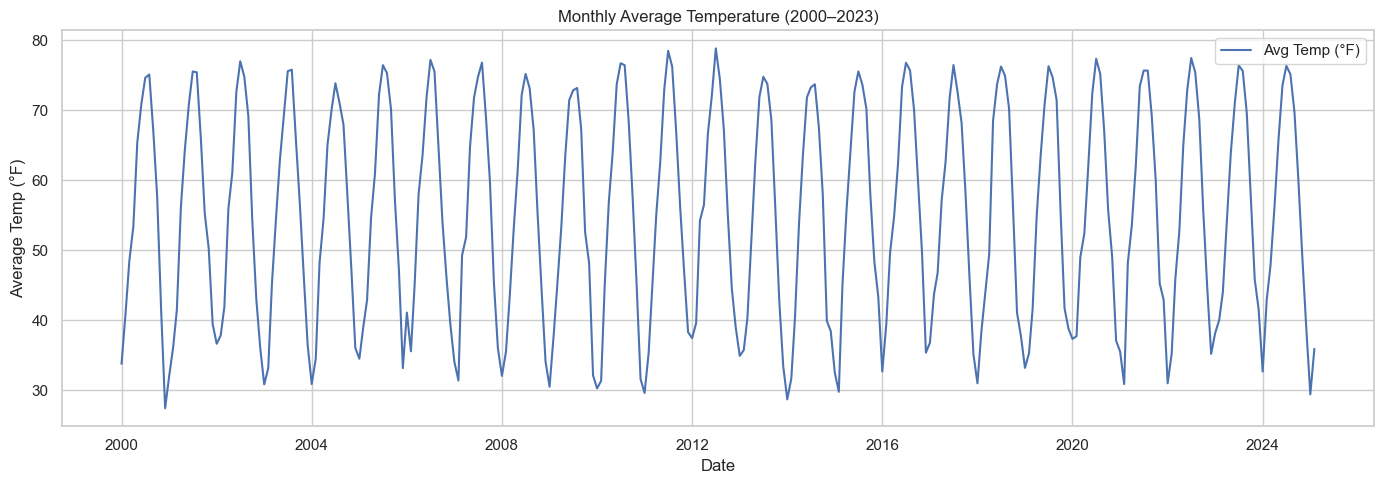

In [12]:
# Convert types
df_climate_trend["year"] = df_climate_trend["year"].astype(int)
df_climate_trend["month"] = df_climate_trend["month"].astype(int)
df_climate_trend["avg_tavg"] = df_climate_trend["avg_tavg"].astype(float)
df_climate_trend["avg_pdsi"] = df_climate_trend["avg_pdsi"].astype(float)

# Create date column
df_climate_trend["date"] = pd.to_datetime(dict(year=df_climate_trend["year"], month=df_climate_trend["month"], day=1))

# Plot average monthly temperature
plt.figure(figsize=(14, 5))
plt.plot(df_climate_trend["date"], df_climate_trend["avg_tavg"], label="Avg Temp (°F)")
plt.title("Monthly Average Temperature (2000–2023)")
plt.xlabel("Date")
plt.ylabel("Average Temp (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


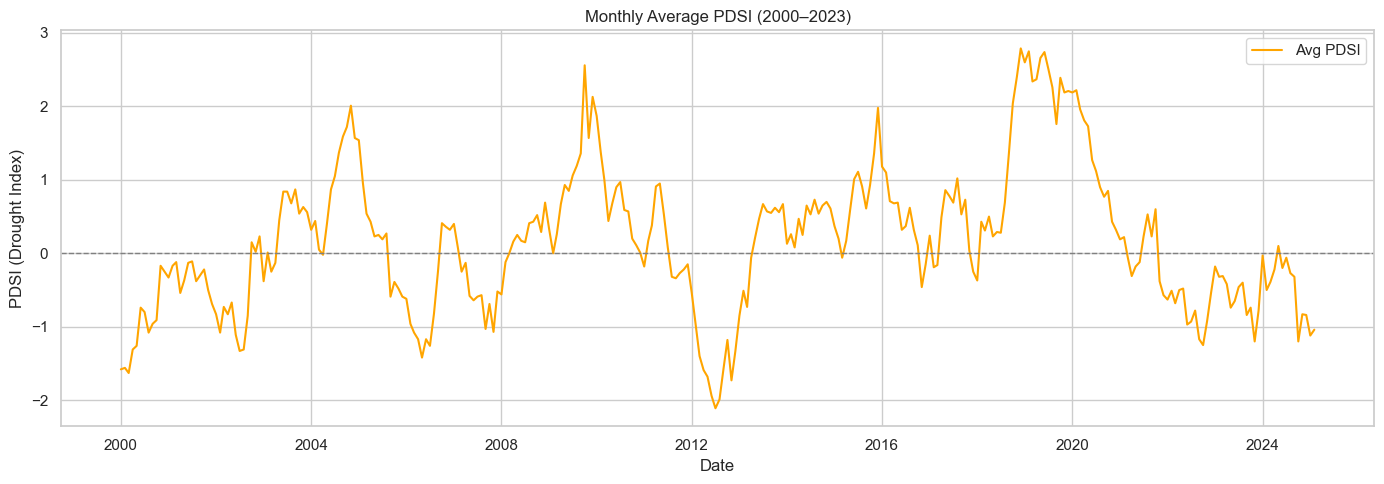

In [13]:
# Plot average monthly PDSI (drought index)
plt.figure(figsize=(14, 5))
plt.plot(df_climate_trend["date"], df_climate_trend["avg_pdsi"], color="orange", label="Avg PDSI")
plt.title("Monthly Average PDSI (2000–2023)")
plt.xlabel("Date")
plt.ylabel("PDSI (Drought Index)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


FPA FOD Dataset Exploration

In [21]:
query_columns = f"""
SELECT * 
FROM "{FPA_FOD_TABLE_NAME}"
LIMIT 1
"""
df_preview = run_athena_query(query_columns, FPA_FOD_DATABASE_NAME)
df_preview.columns.tolist()


['fod_id',
 'fpa_id',
 'source_system_type',
 'source_system',
 'nwcg_reporting_agency',
 'nwcg_reporting_unit_id',
 'nwcg_reporting_unit_name',
 'source_reporting_unit',
 'source_reporting_unit_name',
 'local_fire_report_id',
 'local_incident_id',
 'fire_code',
 'fire_name',
 'ics_209_plus_incident_join_id',
 'ics_209_plus_complex_join_id',
 'mtbs_id',
 'mtbs_fire_name',
 'complex_name',
 'fire_year',
 'discovery_date',
 'discovery_doy',
 'discovery_time',
 'nwcg_cause_classification',
 'nwcg_general_cause',
 'nwcg_cause_age_category',
 'cont_date',
 'cont_doy',
 'cont_time',
 'fire_size',
 'fire_size_class',
 'latitude',
 'longitude',
 'owner_descr',
 'state',
 'county',
 'fips_code',
 'fips_name',
 'geometry']

In [26]:
# Previewed from your table schema
columns = [
    'fod_id', 'fpa_id', 'source_system_type', 'source_system',
    'nwcg_reporting_agency', 'nwcg_reporting_unit_id', 'nwcg_reporting_unit_name',
    'source_reporting_unit', 'source_reporting_unit_name', 'local_fire_report_id',
    'local_incident_id', 'fire_code', 'fire_name', 'ics_209_plus_incident_join_id',
    'ics_209_plus_complex_join_id', 'mtbs_id', 'mtbs_fire_name', 'complex_name',
    'fire_year', 'discovery_date', 'discovery_doy', 'discovery_time',
    'nwcg_cause_classification', 'nwcg_general_cause', 'nwcg_cause_age_category',
    'cont_date', 'cont_doy', 'cont_time', 'fire_size', 'fire_size_class',
    'latitude', 'longitude', 'owner_descr', 'state', 'county',
    'fips_code', 'fips_name', 'geometry'
]

df_nulls = pd.DataFrame(columns=["column", "null_count"])

for col in columns:
    query = f"""
    SELECT COUNT(*) - COUNT({col}) AS null_count
    FROM "{FPA_FOD_TABLE_NAME}"
    """
    try:
        result = run_athena_query(query, FPA_FOD_DATABASE_NAME)
        df_nulls = pd.concat([
            df_nulls,
            pd.DataFrame({ "column": [col], "null_count": [int(result.iloc[0, 0])] })
        ])
    except Exception as e:
        print(f"⚠️ Failed on column: {col} | Reason: {str(e)}")

df_nulls = df_nulls.reset_index(drop=True)
df_nulls.sort_values(by="null_count", ascending=False)


,column,null_count
34,county,2126592
7,source_reporting_unit,2030905
9,local_fire_report_id,1831739
27,cont_time,1002010
26,cont_doy,932566
35,fips_code,785598
21,discovery_time,753625
18,fire_year,127884
20,discovery_doy,115468
30,latitude,115374


In [24]:
query_causes_cleaned = f"""
SELECT 
    nwcg_general_cause AS cause,
    COUNT(*) AS count
FROM "{FPA_FOD_TABLE_NAME}"
WHERE nwcg_general_cause IS NOT NULL AND TRIM(nwcg_general_cause) != ''
GROUP BY nwcg_general_cause
ORDER BY count DESC
LIMIT 15
"""
df_causes = run_athena_query(query_causes_cleaned, FPA_FOD_DATABASE_NAME)
df_causes["count"] = df_causes["count"].astype(int)


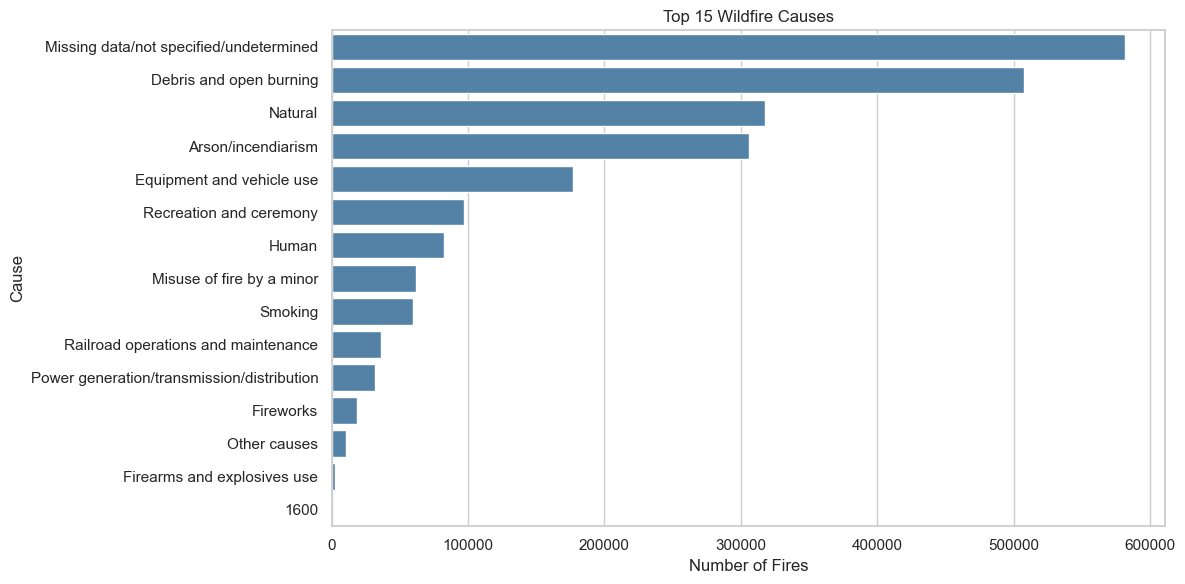

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_causes, x="count", y="cause", color="steelblue")
plt.title("Top 15 Wildfire Causes")
plt.xlabel("Number of Fires")
plt.ylabel("Cause")
plt.tight_layout()
plt.show()


In [17]:
query_size_distribution = f"""
SELECT 
    fire_size
FROM "{FPA_FOD_TABLE_NAME}"
WHERE fire_size IS NOT NULL
"""

df_size = run_athena_query(query_size_distribution, FPA_FOD_DATABASE_NAME)
df_size["fire_size"] = df_size["fire_size"].astype(float)
df_size = df_size[df_size["fire_size"] > 0]  # Remove 0-acre entries


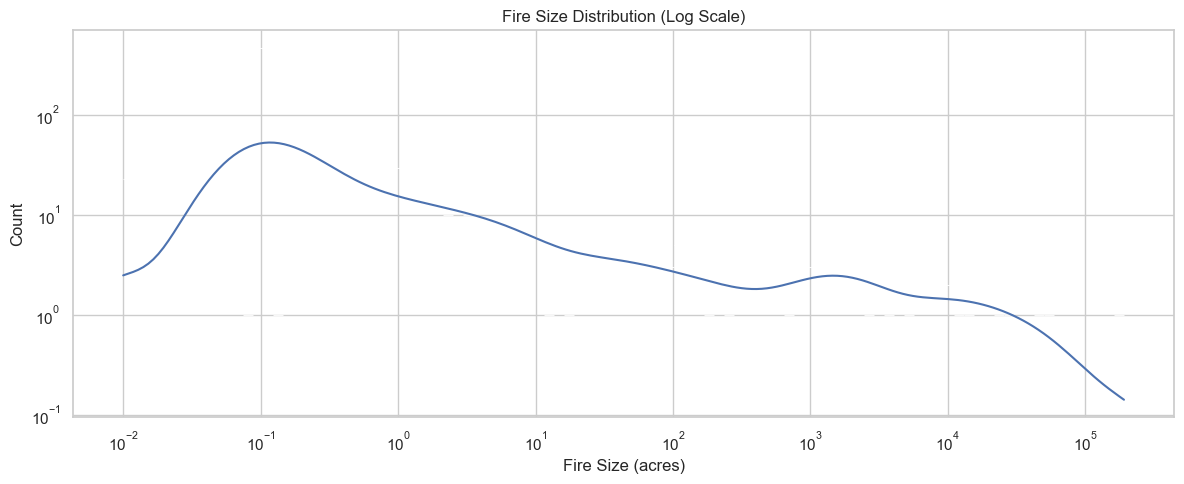

In [18]:
# Plot fire size distribution (log scale)
plt.figure(figsize=(12, 5))
sns.histplot(df_size["fire_size"], bins=100, log_scale=(True, True), kde=True)
plt.title("Fire Size Distribution (Log Scale)")
plt.xlabel("Fire Size (acres)")
plt.tight_layout()
plt.show()


In [19]:
query_state_counts = f"""
SELECT 
    state,
    COUNT(*) AS fire_count
FROM "{FPA_FOD_TABLE_NAME}"
GROUP BY state
ORDER BY fire_count DESC
LIMIT 10
"""

df_states = run_athena_query(query_state_counts, FPA_FOD_DATABASE_NAME)
df_states["fire_count"] = df_states["fire_count"].astype(int)
df_states


,state,fire_count
0,CA,196831
1,TX,178870
2,GA,139774
3,NC,130130
4,AZ,104950
5,FL,103380
6,NY,99139
7,SC,88051
8,MS,84706
9,OR,71431


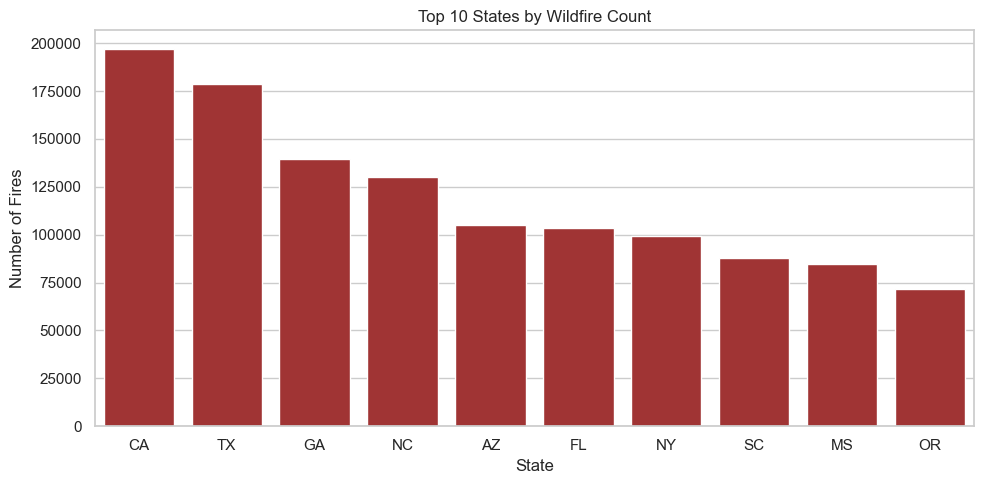

In [20]:
# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_states, x="state", y="fire_count", color="firebrick")
plt.title("Top 10 States by Wildfire Count")
plt.xlabel("State")
plt.ylabel("Number of Fires")
plt.tight_layout()
plt.show()


Data Cleaning on FPA FOD

In [43]:
query_filtered_fpa_fod = f"""
SELECT
    fpa_id,
    fire_year,
    discovery_date,
    discovery_doy,
    nwcg_cause_classification,
    nwcg_general_cause,
    fire_size,
    fire_size_class,
    latitude,
    longitude,
    state,
    county,
    fips_code,
    fips_name,
    geometry
FROM "{FPA_FOD_DATABASE_NAME}"."{FPA_FOD_TABLE_NAME}"
WHERE fire_size > 1000
"""


In [77]:
df_fpa_large = run_athena_query_full(query_filtered_fpa_fod, FPA_FOD_DATABASE_NAME)

In [78]:
df_fpa_large.shape

(35429, 15)

In [79]:
df_fpa_large.head()

,fpa_id,fire_year,discovery_date,discovery_doy,nwcg_cause_classification,nwcg_general_cause,fire_size,fire_size_class,latitude,longitude,state,county,fips_code,fips_name,geometry
0,ICS209_2016_4326262,2016.0,3/8/2016,68.0,Human,Missing data/not specified/undetermined,7500.0,G,30.479167,-86.826389,FL,NaN,12113.0,Santa Rosa County,POINT (-86.82638416099996 30.479161065000028)
1,ICS209_2017_7133019,2017.0,7/13/2017,194.0,Natural,Natural,3621.0,F,46.048783,-113.646767,MT,NaN,30039.0,Granite County,POINT (-113.64675403099994 46.04877659300007)
2,ICS209_2016_4384597,2016.0,6/30/2016,182.0,Human,Missing data/not specified/undetermined,3400.0,F,45.624444,-121.066944,OR,NaN,41065.0,Wasco County,POINT (-121.06693015399998 45.62443876400005)
3,ICS209_2017_7141806,2017.0,3/3/2017,62.0,Human,Missing data/not specified/undetermined,2412.0,F,35.905833,-98.179444,OK,NaN,40073.0,Kingfisher County,POINT (-98.17943630899998 35.90582706300006)
4,ICS209_2015_2843682,2015.0,6/20/2015,171.0,Natural,Natural,2000.0,F,64.966667,-155.716667,AK,NaN,2290.0,Yukon-Koyukuk Census Area,POINT (-155.71664080899998 64.96666631300008)


In [80]:
df_fpa_large.columns

Index(['fpa_id', 'fire_year', 'discovery_date', 'discovery_doy',
       'nwcg_cause_classification', 'nwcg_general_cause', 'fire_size',
       'fire_size_class', 'latitude', 'longitude', 'state', 'county',
       'fips_code', 'fips_name', 'geometry'],
      dtype='object')

In [81]:
df_fpa_large.isnull().sum().sort_values(ascending=False)

county                       33457
fips_code                    25842
fire_year                    21737
discovery_doy                21737
latitude                     21733
fips_name                     5991
geometry                       747
nwcg_general_cause               4
longitude                        4
fpa_id                           0
discovery_date                   0
nwcg_cause_classification        0
fire_size                        0
fire_size_class                  0
state                            0
dtype: int64

In [82]:
import re

def parse_geometry_point(geom_str):
    match = re.match(r"POINT \(([-\d\.]+) ([-\d\.]+)\)", str(geom_str))
    if match:
        lon, lat = match.groups()
        return float(lat), float(lon)
    return None, None

df_fpa_large[["latitude_parsed", "longitude_parsed"]] = df_fpa_large["geometry"].apply(
    lambda g: pd.Series(parse_geometry_point(g))
)


In [83]:
df_fpa_large["latitude"] = df_fpa_large["latitude"].fillna(df_fpa_large["latitude_parsed"])
df_fpa_large["longitude"] = df_fpa_large["longitude"].fillna(df_fpa_large["longitude_parsed"])


In [ ]:
!pip install geopandas

In [84]:
import geopandas as gpd

# Load the county shapefile
county_shapefile_path = "data/shapefiles/cb_2018_us_county_5m/cb_2018_us_county_5m.shp"
gdf_counties = gpd.read_file(county_shapefile_path)

# Display the columns
print(gdf_counties.columns)


Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [85]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1. Load the cleaned FPA/FOD DataFrame with lat/lon
df = df_fpa_large.copy()

# 2. Filter invalid/missing lat/lon before converting to GeoDataFrame and restrict to US Continental
df = df.dropna(subset=["latitude", "longitude"])
df = df[df["latitude"].between(24, 50) & df["longitude"].between(-125, -65)]

# 3. Convert to GeoDataFrame
gdf_fires = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# 4. Load county shapefile (2023 or latest preferred)
county_shapefile_path = "data/shapefiles/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
gdf_counties = gpd.read_file(county_shapefile_path)

# 5. Ensure geometry is valid (fix potential invalid shapes)
gdf_counties["geometry"] = gdf_counties["geometry"].buffer(0)

# 6. Ensure matching CRS
gdf_counties = gdf_counties.to_crs(gdf_fires.crs)

# 7. Use sjoin_nearest for robust zero-drop spatial join
gdf_joined = gpd.sjoin_nearest(
    gdf_fires,
    gdf_counties[["STATEFP", "COUNTYFP", "NAME", "geometry"]],
    how="left",
    distance_col="dist_to_county"
)

# 8. Create full FIPS code and fill missing county names
gdf_joined["fips_code"] = gdf_joined["fips_code"].fillna(
    gdf_joined["STATEFP"].astype(str).str.zfill(2) + gdf_joined["COUNTYFP"].astype(str).str.zfill(3)
)
gdf_joined["county"] = gdf_joined["county"].fillna(gdf_joined["NAME"])

# 9. Drop unnecessary columns from join
gdf_cleaned = gdf_joined.drop(columns=["index_right", "STATEFP", "COUNTYFP", "NAME", "dist_to_county"])

# 10. Confirm missing values after join
missing_summary = gdf_cleaned[["fips_code", "county"]].isnull().sum()
print("Remaining missing values:\n", missing_summary)

# Optional: preview results
gdf_cleaned[["fpa_id", "state", "county", "fips_code", "latitude", "longitude"]].head()


/Users/harshakatreddy/wildfire-risk-analytics/.venv/lib/python3.13/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Remaining missing values:
 fips_code    0
county       0
dtype: int64


,fpa_id,state,county,fips_code,latitude,longitude
0,ICS209_2016_4326262,FL,Santa Rosa,12113.0,30.479167,-86.826389
1,ICS209_2017_7133019,MT,Granite,30039.0,46.048783,-113.646767
2,ICS209_2016_4384597,OR,Wasco,41065.0,45.624444,-121.066944
3,ICS209_2017_7141806,OK,Kingfisher,40073.0,35.905833,-98.179444
5,ICS209_2016_4383413,FL,Okaloosa,12091.0,30.649722,-86.651667


In [87]:
# Count nulls in each column and sort
null_counts = gdf_cleaned.isnull().sum().sort_values(ascending=False)

# Display the result
print("Null counts by column:")
print(null_counts)

gdf_cleaned.shape

Null counts by column:
fips_name                    4160
longitude_parsed               11
latitude_parsed                11
longitude                       0
geometry                        0
fips_code                       0
county                          0
state                           0
fpa_id                          0
fire_year                       0
fire_size_class                 0
fire_size                       0
nwcg_general_cause              0
nwcg_cause_classification       0
discovery_doy                   0
discovery_date                  0
latitude                        0
dtype: int64


(12337, 17)

In [89]:
gdf_cleaned.drop(columns=["latitude_parsed", "longitude_parsed","fips_name"], inplace=True)


In [90]:
# Save locally as CSV (geometry will be removed)
gdf_cleaned.drop(columns="geometry").to_csv("data/cleaned_fpa_fod.csv", index=False)

In [91]:
import geopandas as gpd
from shapely.geometry import Point

# Ensure geometry column exists and is valid
gdf_cleaned["geometry"] = gdf_cleaned.apply(
    lambda row: Point(row["longitude"], row["latitude"]),
    axis=1
)
gdf_cleaned = gpd.GeoDataFrame(gdf_cleaned, geometry="geometry", crs="EPSG:4326")


In [92]:
top_fires = gdf_cleaned.sort_values(by="fire_size", ascending=False).head(500)


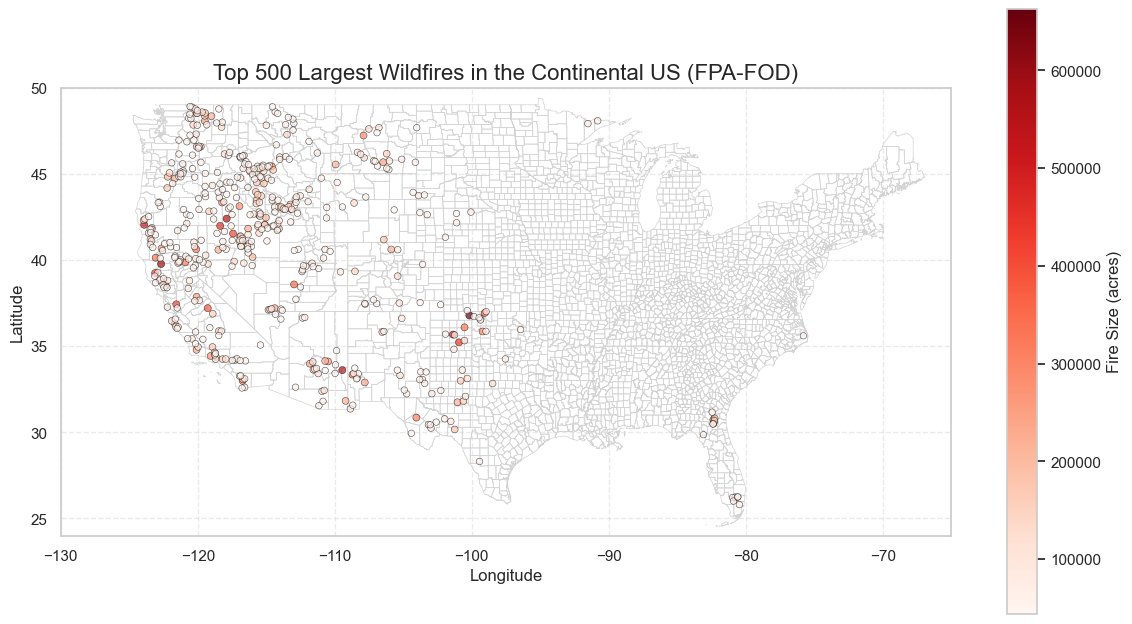

In [96]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Filter top 500 largest wildfires
top_fires = gdf_cleaned.sort_values(by="fire_size", ascending=False).head(500).copy()

# Scale marker size using log to reduce skew (more visually balanced)
import numpy as np
top_fires["marker_size"] = np.log1p(top_fires["fire_size"]) * 2

# Convert to GeoDataFrame
gdf_top_fires = gpd.GeoDataFrame(
    top_fires,
    geometry=gpd.points_from_xy(top_fires["longitude"], top_fires["latitude"]),
    crs="EPSG:4326"
)

# Limit counties to continental US (exclude AK, HI, PR by state FIPS)
exclude_states = ["02", "15", "72"]  # AK, HI, PR
gdf_counties_contiguous = gdf_counties[~gdf_counties["STATEFP"].isin(exclude_states)]

# Plot
fig, ax = plt.subplots(figsize=(12, 9))

# Plot base map (county boundaries)
gdf_counties_contiguous.boundary.plot(ax=ax, color="lightgray", linewidth=0.5, zorder=1)

# Plot top 500 fires
gdf_top_fires.plot(
    ax=ax,
    column="fire_size",
    cmap="Reds",
    markersize=gdf_top_fires["marker_size"],
    legend=True,
    alpha=0.7,
    edgecolor="black",
    linewidth=0.4,
    legend_kwds={'label': "Fire Size (acres)", 'shrink': 0.7},
    zorder=2
)

# Aesthetics
ax.set_title("Top 500 Largest Wildfires in the Continental US (FPA-FOD)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


EDA for nlimdiv and wrc tables

In [97]:
# Reusable function for null audits
def audit_nulls_athena(columns, table_name, database_name):
    df_nulls = pd.DataFrame(columns=["column", "null_count"])
    for col in columns:
        query = f'SELECT COUNT(*) - COUNT("{col}") AS null_count FROM "{table_name}"'
        try:
            result = run_athena_query(query, database=database_name)
            df_nulls = pd.concat([
                df_nulls,
                pd.DataFrame({"column": [col], "null_count": [int(result.iloc[0, 0])]})
            ])
        except Exception as e:
            print(f"Failed on column: {col} | Reason: {e}")
    return df_nulls.reset_index(drop=True).sort_values(by="null_count", ascending=False)


In [99]:
# Row count
run_athena_query(f"SELECT COUNT(*) FROM {NCLIMDIV_TABLE_NAME}", NCLIMDIV_DATABASE_NAME)

# Show columns
run_athena_query(f"SHOW COLUMNS IN {NCLIMDIV_TABLE_NAME}", NCLIMDIV_DATABASE_NAME)

# Null audit
nclimdiv_cols = [
    "state_code", "county_fips", "year", "month", "precipitation", 
    "pdsi", "tmax", "tmin", "tavg"
]
df_nulls_nclimdiv = audit_nulls_athena(nclimdiv_cols, NCLIMDIV_TABLE_NAME, NCLIMDIV_DATABASE_NAME)



In [102]:
df_nulls_nclimdiv

,column,null_count
5,pdsi,69530
4,precipitation,31420
0,state_code,0
1,county_fips,0
2,year,0
3,month,0
6,tmax,0
7,tmin,0
8,tavg,0


In [100]:
# Row count
run_athena_query(f"SELECT COUNT(*) FROM {WRC_TABLE_NAME}", WRC_DATABASE_NAME)

# Show columns
run_athena_query(f"SHOW COLUMNS IN {WRC_TABLE_NAME}", WRC_DATABASE_NAME)

# Null audit
wrc_cols = [
    "geoid", "stusps", "name", "state_name", "statefp", "countyfp", 
    "ea_huexposed", "ea_hurisk", "ea_hurisk_state_rank", "ea_hurisk_fraction_ie"
]
df_nulls_wrc = audit_nulls_athena(wrc_cols, WRC_TABLE_NAME, WRC_DATABASE_NAME)


In [103]:
df_nulls_wrc

,column,null_count
4,statefp,3144
6,ea_huexposed,1
7,ea_hurisk,1
8,ea_hurisk_state_rank,1
9,ea_hurisk_fraction_ie,1
0,geoid,0
1,stusps,0
2,name,0
3,state_name,0
5,countyfp,0


In [ ]:
def run_athena_ddl(query, database):
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={"Database": database},
        ResultConfiguration={"OutputLocation": ATHENA_OUTPUT_LOCATION}
    )
    execution_id = response["QueryExecutionId"]

    while True:
        status = athena.get_query_execution(QueryExecutionId=execution_id)["QueryExecution"]["Status"]["State"]
        if status == "SUCCEEDED":
            print(f"✅ Query succeeded: {execution_id}")
            break
        elif status == "FAILED":
            reason = athena.get_query_execution(QueryExecutionId=execution_id)["QueryExecution"]["Status"].get("StateChangeReason", "")
            raise Exception(f"❌ Query failed: {execution_id}\nReason: {reason}")
        time.sleep(1)



# Step 1: Impute missing pdsi and precipitation in nClimDiv
query_impute_nclimdiv = f"""
CREATE OR REPLACE VIEW nclimdiv_imputed AS
SELECT 
    *,
    COALESCE(pdsi, AVG(pdsi) OVER (PARTITION BY county_fips, month)) AS pdsi_imputed,
    COALESCE(precipitation, AVG(precipitation) OVER (PARTITION BY county_fips, month)) AS precipitation_imputed
FROM "{NCLIMDIV_TABLE_NAME}";
"""

# Step 2: Add GEOID to nClimDiv
query_nclimdiv_geoid = """
CREATE OR REPLACE VIEW nclimdiv_with_geoid AS
SELECT
    LPAD(CAST(state_code AS VARCHAR), 2, '0') || LPAD(CAST(county_fips AS VARCHAR), 3, '0') AS geoid,
    *
FROM nclimdiv_imputed;
"""



# Execute each query in Athena
print("▶️ Imputing nClimDiv...")
run_athena_ddl(query_impute_nclimdiv, NCLIMDIV_DATABASE_NAME)

print("✅ GEOID creation...")
run_athena_ddl(query_nclimdiv_geoid, NCLIMDIV_DATABASE_NAME)



In [109]:
# Step 3: Normalize wildfire risk indicators in WRC
query_wrc_normalize = f"""
CREATE OR REPLACE VIEW wrc_normalized AS
SELECT 
    *,
    100 * (ea_hurisk - MIN(ea_hurisk) OVER ()) / NULLIF(MAX(ea_hurisk) OVER () - MIN(ea_hurisk) OVER (), 0) AS ea_hurisk_norm,
    100 * (bp_mean - MIN(bp_mean) OVER ()) / NULLIF(MAX(bp_mean) OVER () - MIN(bp_mean) OVER (), 0) AS bp_mean_norm,
    100 * (whp_mean - MIN(whp_mean) OVER ()) / NULLIF(MAX(whp_mean) OVER () - MIN(whp_mean) OVER (), 0) AS whp_mean_norm
FROM "{WRC_TABLE_NAME}";
"""

# Step 4: Clean WRC by dropping rows with nulls in key metrics and 'statefp'
query_wrc_clean = """
CREATE OR REPLACE VIEW wrc_cleaned AS
SELECT *
FROM wrc_normalized
WHERE statefp IS NOT NULL
  AND ea_hurisk IS NOT NULL
  AND bp_mean IS NOT NULL
  AND whp_mean IS NOT NULL;
"""


In [110]:
print("📊 Normalizing WRC metrics...")
run_athena_ddl(query_wrc_normalize, WRC_DATABASE_NAME)

print("🧹 Cleaning WRC...")
run_athena_ddl(query_wrc_clean, WRC_DATABASE_NAME)

print("✅ All views created successfully.")


📊 Normalizing WRC metrics...
✅ Query succeeded: fbe97558-3922-4c41-9a2c-56d63897183b
🧹 Cleaning WRC...
✅ Query succeeded: 790665e5-7363-448b-bce0-9f67811c1c08
✅ All views created successfully.


In [106]:
query_show_wrc_columns = f"SHOW COLUMNS IN {WRC_TABLE_NAME}"
run_athena_query(query_show_wrc_columns, WRC_DATABASE_NAME)


,geoid
0,stusps
1,name
2,state_name
3,statefp
4,countyfp
5,countyns
6,total_land_area
7,la_fraction_me
8,la_fraction_ie
9,la_fraction_de
